In [11]:
import pandas as pd 
import numpy as np
import seaborn as sns

In [4]:
orders = pd.read_csv("orders.csv")
nodes  = pd.read_csv("nodes.csv")

In [9]:
orders.running_time = pd.to_datetime(orders.running_time)
orders.completed_time = pd.to_datetime(orders.completed_time)

orders

,Id,running_time,completed_time,route_distance_km,delta_time
0,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0
1,-1446874864726772723,2022-01-24 18:31:03,2022-01-24 18:44:03,2.766,780.0
2,-7109832734562886369,2022-01-24 07:33:11,2022-01-24 07:38:33,2.022,322.0
3,5574536568610609787,2022-01-24 17:23:20,2022-01-24 17:35:11,4.309,711.0
4,-9022427340295022993,2022-01-24 18:01:45,2022-01-24 18:07:09,1.819,324.0
...,...,...,...,...,...
5995,2992719274882466990,2022-01-24 15:44:22,2022-01-24 15:58:59,5.286,877.0
5996,1804461572065829634,2022-01-24 13:47:30,2022-01-24 14:00:49,5.397,799.0
5997,-8300017207212222422,2022-01-24 10:38:59,2022-01-24 10:50:25,4.353,686.0
5998,-2106426041999836644,2022-01-24 12:48:39,2022-01-24 12:54:15,2.055,336.0


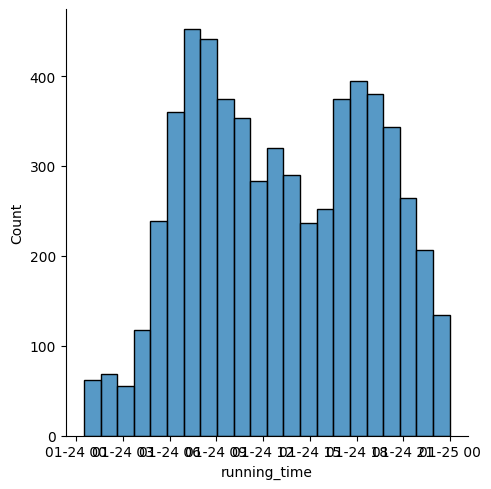

In [12]:
sns.displot(orders.running_time)

In [6]:
nodes

,Id,node_start,node_finish,distance,speed
0,1403210517021349791,290773715,2041636852,64.755864,36.0
1,1403210517021349791,290773722,2163829963,59.012828,36.0
2,1403210517021349791,290773723,3129305123,8.709567,34.0
3,1403210517021349791,291071720,5216935099,275.796769,33.0
4,1403210517021349791,297978510,3684572319,8.141696,38.0
...,...,...,...,...,...
490732,3549078804595803823,8952439761,317189358,4.847930,23.0
490733,3549078804595803823,8952439762,8952439761,131.325685,26.0
490734,3549078804595803823,8952439763,8952439762,44.026544,38.0
490735,3549078804595803823,8952439764,8952439763,0.111226,34.0


In [14]:
df = pd.merge(orders, nodes, left_on='Id', right_on='Id')
df

,Id,running_time,completed_time,route_distance_km,delta_time,node_start,node_finish,distance,speed
0,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,27128515,2071748215,12.679597,30.0
1,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290954292,6617360936,60.818847,27.0
2,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290954407,7843425705,5.872602,27.0
3,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290957532,4429141860,24.343623,24.0
4,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290957894,5514511519,5.789114,29.0
...,...,...,...,...,...,...,...,...,...
490732,6245370800473439030,2022-01-24 08:45:45,2022-01-24 08:53:31,2.220,466.0,8018283981,290007862,13.356626,28.0
490733,6245370800473439030,2022-01-24 08:45:45,2022-01-24 08:53:31,2.220,466.0,8018283983,4439629628,23.704346,24.0
490734,6245370800473439030,2022-01-24 08:45:45,2022-01-24 08:53:31,2.220,466.0,8952470950,287688120,4.845448,22.0
490735,6245370800473439030,2022-01-24 08:45:45,2022-01-24 08:53:31,2.220,466.0,8952470952,8952470950,105.114942,21.5


In [17]:
df[(df.node_start == 27128515) & (df.node_finish == 2071748215)]

,Id,running_time,completed_time,route_distance_km,delta_time,node_start,node_finish,distance,speed
0,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,27128515,2071748215,12.679597,30.0
11740,4474528409037641844,2022-01-24 14:56:36,2022-01-24 15:04:44,3.274,488.0,27128515,2071748215,12.679675,22.0
88569,-794361648044380087,2022-01-24 21:53:06,2022-01-24 21:59:14,2.982,368.0,27128515,2071748215,12.679597,20.0
99838,6013822553034534606,2022-01-24 17:12:41,2022-01-24 17:22:59,3.487,618.0,27128515,2071748215,12.679597,31.0
160190,4437099521260763966,2022-01-24 12:34:48,2022-01-24 12:43:46,4.867,538.0,27128515,2071748215,12.679597,24.0
174906,-8719367728188011770,2022-01-24 19:10:58,2022-01-24 19:18:35,2.807,457.0,27128515,2071748215,12.679597,22.0
215518,425142730824544874,2022-01-24 06:02:29,2022-01-24 06:07:13,2.161,284.0,27128515,2071748215,12.679597,33.0
324748,928442239737264937,2022-01-24 05:39:25,2022-01-24 05:45:40,1.484,375.0,27128515,2071748215,12.679597,30.0
433348,1467168845263183769,2022-01-24 22:03:26,2022-01-24 22:06:48,0.729,202.0,27128515,2071748215,12.679649,34.0


In [18]:
df[df.Id == 7013180891535596072]

,Id,running_time,completed_time,route_distance_km,delta_time,node_start,node_finish,distance,speed
0,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,27128515,2071748215,12.679597,30.0
1,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290954292,6617360936,60.818847,27.0
2,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290954407,7843425705,5.872602,27.0
3,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290957532,4429141860,24.343623,24.0
4,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,290957894,5514511519,5.789114,29.0
...,...,...,...,...,...,...,...,...,...
81,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,7843425705,7024024852,13.345910,29.0
82,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,8211035254,5871806796,20.602990,56.0
83,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,8952449231,290959294,6.001176,29.0
84,7013180891535596072,2022-01-24 11:04:12,2022-01-24 11:14:07,4.061,595.0,8952457882,5871805741,5.664902,30.0
